<a href="https://colab.research.google.com/github/jajapuramshivasai/Q24_2/blob/main/n_dim_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('animation', html='jshtml')

# CODE FOR PREPARING INITIAL 2D WAVE FROM SUPERPOSITION #

In [ ]:

def sine_wave(U,wave_freq,wave_num_x,wave_num_y,t):
  l = len(U[0])
  omega = np.pi*wave_freq
  kx = (wave_num_x/(l-1))*np.pi
  ky = (wave_num_y/(l-1))*np.pi

  for i in range(l):
    for j in range(l):
      U[i][j] = np.sin(kx*i)*np.sin(ky*j)*np.cos(omega*t)
  return U

def gen_U(U,params,t):

  for param in params:
    U += sine_wave(U,param[0],param[1],param[2],t)
  return U/len(params)

In [ ]:
params = [
    [1,2,2],
    [0.5,1,3],
    [0.25,2,4]
]

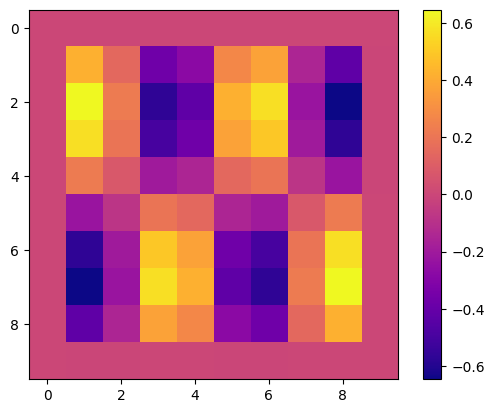

In [ ]:
U = np.zeros((10,10))

U_ = gen_U(U,params,0)


plt.imshow(U_, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()


# CODE FOR HHL LINEAR SOLVER  #

In [ ]:
def is_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def is_power_of_two(n):
  return (n & (n-1) == 0) and n != 0


def HHL(A,b):
  if is_symmetric(A) and is_power_of_two(A.shape[0]):
    # Perform HHL algorithm here
    x = np.linalg.solve(A, b)
    return x
  else:
    print("Matrix A does not meet the criteria.")


In [ ]:
# Example usage:
A = np.array([[1, 0], [0, 1]])
b = np.array([1, 0])

x = HHL(A, b)
print(x)

[1. 0.]


# CODE FOR PREPARING MATRIX A #

[[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]


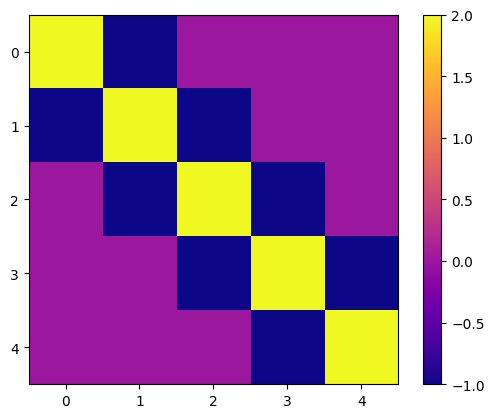

In [2]:
def create_custom_diagonal_matrix(n, diagonals):
    # Initialize an empty matrix
    A = np.zeros((n, n))

    # Fill the matrix with the given diagonal values
    for position, value in diagonals:
        diag_values = np.full(n - abs(position), value)
        A += np.diag(diag_values, k=position)

    return A

# Example usage
n = 5  # Dimension of the matrix
diagonals = [
    (0, 2.0),   # Main diagonal
    (-1, -1.0), # Sub-diagonal
    (1, -1.0)   # Super-diagonal
]

A = create_custom_diagonal_matrix(n, diagonals)
print(A)


plt.imshow(A, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

In [3]:
Nx = 5
Ny = 5
rx = 1
ry = 1
# Create the 2D Laplacian matrix (using a 5-point stencil)
A = np.zeros(((Nx + 1) * (Ny + 1), (Nx + 1) * (Ny + 1)))
for i in range(1, Nx):
    for j in range(1, Ny):
        index = i * (Ny + 1) + j
        A[index, index] = 1 + 2 * rx**2 + 2 * ry**2
        A[index, index - (Ny + 1)] = -rx**2
        A[index, index + (Ny + 1)] = -rx**2
        A[index, index - 1] = -ry**2
        A[index, index + 1] = -ry**2

# Boundary conditions (assuming Dirichlet boundary conditions)
# Set the boundary elements of A to 1 (identity)
for i in [0, Nx]:
    for j in range(Ny + 1):
        index = i * (Ny + 1) + j
        A[index, index] = 1
for j in [0, Ny]:
    for i in range(Nx + 1):
        index = i * (Ny + 1) + j
        A[index, index] = 1


In [4]:
def prep_diag(dimension,length,r):
  diagonals= [
      (0,2*dimension*r**2+1)
  ]
  for i in range(1,dimension+1):
    k=(length+1)**(i-1)
    diagonals.append((-k, -r**2))
    diagonals.append((k, -r**2))
  return diagonals

D = prep_diag(2,5,1)
print(D)
D_ = create_custom_diagonal_matrix((5+1)**2,D)

[(0, 5), (-1, -1), (1, -1), (-6, -1), (6, -1)]


In [5]:
def get_A(dimension,length,r):
  D = prep_diag(dimension,length,r)
  A = create_custom_diagonal_matrix((length+1)**2,D)
  return A

### Textbook approach for preparing matrix A

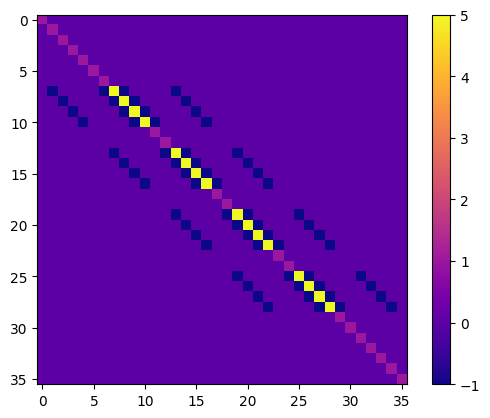

In [6]:
plt.imshow(A, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

### Our approach for preparing matrix A such that A is symmetris so it could be solved using HHl Algorithm

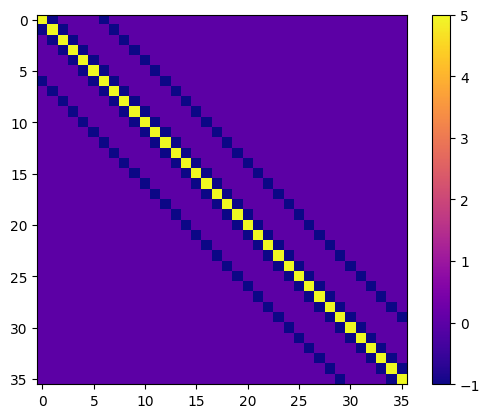

In [7]:
A = get_A(2,5,1)
plt.imshow(A, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

# CODE FOR SIMULATION OF 2D WAVE #

In [ ]:
# Simulation parameters
Lx = 1.0  # Length of the domain in x
Ly = 1.0  # Length of the domain in y
T = 0.6   # Total time
c = 1.0   # Wave speed
Nx = 31    # Number of spatial grid points in x
Ny = 31   # Number of spatial grid points in y
Nt = 30    # Number of time steps
dx = Lx / Nx
dy = Ly / Ny
dt = T / Nt
rx = c * dt / dx
ry = c * dt / dy

# Spatial grid
x = np.linspace(0, Lx, Nx + 1)
y = np.linspace(0, Ly, Ny + 1)
X, Y = np.meshgrid(x, y)

# Initial conditions

U = np.zeros((Nx+1,Ny+1))
U0 = gen_U(U,params,0)
U1 = gen_U(U,params,dt)

u0 = U0
u1 = U1


#preparing matrix A

A_ = get_A(2,Nx,rx)
A = A_


# Time stepping


u = np.zeros((Nt + 1, (Nx + 1) * (Ny + 1)))
u[0, :] = u0.flatten()
u[1, :] = u1.flatten()

for n in range(1, Nt):
    b = 2 * u[n] - u[n - 1]

    # Solve for the next time step using HHl
    u[n + 1, :] = HHL(A, b)

    # Apply boundary conditions to the right-hand side |b>

    b[:Ny+1] = 0  # Bottom boundary
    b[Nx*(Ny+1):] = 0  # Top boundary
    b[::Ny+1] = 0  # Left boundary
    b[Ny::Ny+1] = 0  # Right boundary

# Reshape the solution back to a 2D grid for visualization
u_2d = u.reshape((Nt + 1, Nx + 1, Ny + 1))



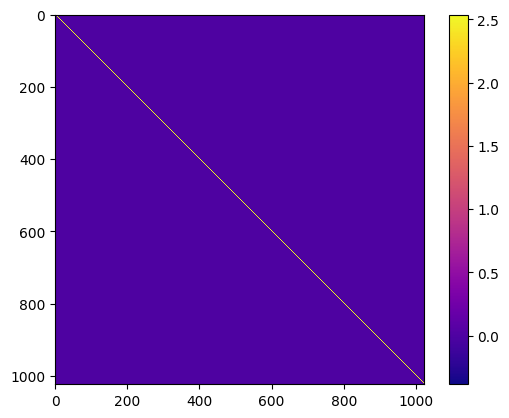

In [ ]:
plt.imshow(A, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

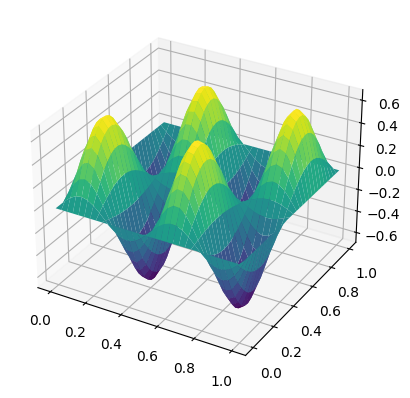

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize the surface plot
surf = ax.plot_surface(X, Y, u_2d[0], cmap='viridis')

# Function to update the surface plot for each frame
def animate(i):
    ax.clear()
    surf = ax.plot_surface(X, Y, u_2d[i], cmap='viridis')
    ax.set_zlim(u_2d.min(), u_2d.max())
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=Nt+1, interval=500, blit=False)

# Display the animation
plt.show()


In [ ]:
ani

In [ ]:
np.set_printoptions(threshold=np.inf)